In [1]:
"""
Copyright 2022 Huawei Technologies Co., Ltd

CREATED:  2022-10-04 13:12:13
MODIFIED: 2022-12-20 06:48:45
"""

# -*- coding:utf-8 -*-
import cv2, sys
import numpy as np
import random as rnd
#
from PIL import Image, ImageDraw
from src.model import preprocessing, postprocessing
# define acllite library path
sys.path.append('../../Common/acllite')
# modules of acllite library
from acllite_model import AclLiteModel
from acllite_resource import AclLiteResource

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# define device id & model path
device_id = 0
model_path = "model/yolov4.om"

# define image & coco_names paths
img_path = "data/person.jpg"
coco_names_path = "data/coco.names"

In [4]:
#load coco names
with open(coco_names_path) as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][0:]

In [5]:
# initialize acllite library
acl_resource = AclLiteResource()
acl_resource.init()
print('[Device] NPU Device id:',acl_resource.device_id)
# load *.om model
model = AclLiteModel(model_path)

init resource stage:
Init resource success
[Device] NPU Device id: 0
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 363888
malloc output 1, size 7277760
Create model output dataset success
Init model resource success


In [6]:
# read image
img_org_bgr = cv2.imread(img_path)

In [7]:
# 1) pre-processing stage
data, model_input_height, model_input_width = preprocessing(img_org_bgr,model._model_desc)

model input size 1
input  0
model input dims ({'name': 'images', 'dimCount': 4, 'dims': [1, 3, 608, 608]}, 0)
model input datatype 0
model output size 2
output  0
model output dims ({'name': 'Concat_1723:0:classes', 'dimCount': 4, 'dims': [1, 22743, 1, 4]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'Concat_1724:0:boxes', 'dimCount': 3, 'dims': [1, 22743, 80]}, 0)
model output datatype 0
[Model] class Model init resource stage success
[PreProc] img_resized shape (3, 608, 608)
[PreProc] image_np_expanded shape (1, 3, 608, 608)


In [8]:
%timeit -n 10 -r 3
result_list = model.execute([data,]) # 2) model execution(forward) stage

In [9]:
# 3) post-processing the raw predictions
bboxes = postprocessing(result_list, img_org_bgr, conf_thresh=0.5, nms_thresh=0.6)

In [10]:
# draw bounding boxes
img = Image.fromarray(img_org_bgr[:,:,::-1])
img1 = ImageDraw.Draw(img)

for bbox in bboxes[0]:
    label = coco_labels[int(bbox[6])]
    print(bbox[:4], bbox[4], bbox[6], label)

    color ="#FF"+''.join([rnd.choice('0123456789ABCDEF') for j in range(4)]) # random color for bounding boxes
    
    img1.rectangle(list(bbox[:4]), outline =color, width=3) # draw bounding boxes
    img1.rectangle((bbox[0], bbox[1], bbox[0] + len(label)*8, bbox[1] + 15), 
                outline = (255,255,255), width=10) # draw box for lable
    
    img1.text((bbox[0]+5, bbox[1]), label, (0,0,0), thickness=10)

[192.8125, 98.236328125, 271.71875, 377.625] 0.9980469 0 person
[61.1328125, 265.20703125, 203.4375, 345.328125] 0.9951172 16 dog
[405.3125, 139.228515625, 601.25, 344.0859375] 0.9863281 17 horse


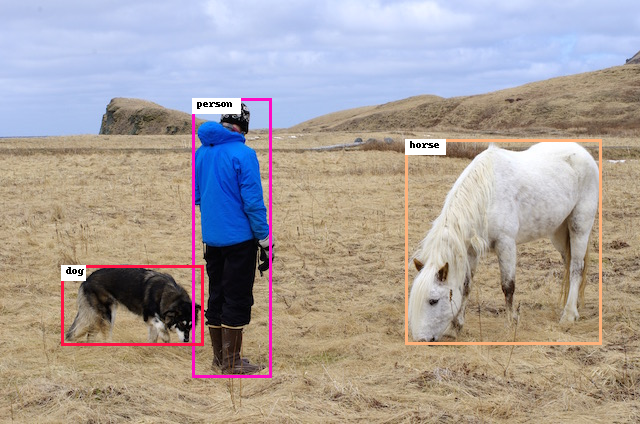

In [11]:
img